In [1]:
# Import libraries

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras import layers

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import pandas as pd
import numpy as np

import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet

Using TensorFlow backend.


In [2]:
# Setup

EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = 500
VALIDATION_SPLIT = 0.3
BATCH_SIZE = 1000
MAX_NB_WORDS = 30000

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
df = pd.read_csv("dataset.csv")
df = df.dropna(subset=['msg', 'role'])
df.describe()

role                                                msg
count     339551                                             339551
unique         7                                              68235
top     Employee  received executed eei master power purchase sa...
freq      113490                                               2660

In [4]:
lines=df['msg'].values.tolist()
labels=df['role'].values.tolist()
review_lines = list()
for line in lines:
    review_lines.append(str(line).split())
review_lines[0]

['chinese',
 'wall',
 'training',
 'one',
 'hour',
 'scheduled',
 'dates',
 'training',
 'mandatory',
 'allows',
 'ews',
 'continue',
 'operating',
 'businesses',
 'including',
 'equity',
 'trading',
 'without',
 'violating',
 'securities',
 'la',
 'ws',
 'please',
 'register',
 'one',
 'four',
 'onehour',
 'sessions',
 'listed',
 'session',
 'tailored',
 'particular',
 'commercial',
 'group',
 'would',
 'preferable',
 'could',
 'attend',
 'session',
 'group',
 'particula',
 'group',
 'one',
 'highlighted',
 'bold',
 'list',
 'monday',
 'march',
 'resource',
 'group',
 'monday',
 'march',
 'originationbusiness',
 'development',
 'monday',
 'march',
 'pm',
 'financial',
 'trading',
 'group',
 'monday',
 'march',
 'pm',
 'heads',
 'trading',
 'desks',
 'sessions',
 'held',
 'downtown',
 'hyatt',
 'regency',
 'hotel',
 'sandalwood',
 'rooms',
 'b',
 'alternatively',
 'two',
 'makeup',
 'sessions',
 'schedul',
 'tuesday',
 'march',
 'pm',
 'pm',
 'location',
 'informatio',
 'makeup',
 'ses

In [5]:
import os
embeddings_index={}
f=open(os.path.join('','glove.twitter.27B.100d.txt'),encoding='utf-8')
for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:])
    embeddings_index[word]=coefs
f.close


<function TextIOWrapper.close()>

In [6]:
labelInt = {'CEO': 0,
 'Director': 1,
 'Employee': 2,
 'Manager': 3,
 'President': 4,
 'Trader': 5,
 'Vice President': 6}

labelsInt = list()
for txt in labels:
    labelsInt.append(labelInt[txt])
labelsInt[:6]

[3, 4, 4, 0, 2, 4]

In [7]:
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
sequences=tokenizer_obj.texts_to_sequences(review_lines)

word_index=tokenizer_obj.word_index

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(len(data))
print(data[1])

encodeLabels = to_categorical(np.asarray(labelsInt))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', encodeLabels.shape)

339551
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0

## Try with ANN

In [8]:
# create a model
model = tf.keras.Sequential()

# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(500, activation='sigmoid',input_shape=(MAX_SEQUENCE_LENGTH,)))
# Add another:
model.add(layers.Dense(500, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.1)))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(7, activation='softmax'))

In [9]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.MeanSquaredError(), #CategoricalCrossentropy
              metrics=METRICS)
model.summary();

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               250500    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 707       
Total params: 551,807
Trainable params: 551,807
Non-trainable params: 0
_________________________________________________________________


In [11]:
# train model
history = model.fit(data, encodeLabels, epochs=20, validation_split=0.4, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')])

Train on 203730 samples, validate on 135821 samples
Epoch 1/20
203730/203730 [==============================] - 46s 224us/sample - loss: 9.5595 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1222380.0000 - fn: 203730.0000 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7365 - val_loss: 9.4753 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 814926.0000 - val_fn: 135821.0000 - val_accuracy: 0.8572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6927
Epoch 2/20
203730/203730 [==============================] - 44s 217us/sample - loss: 9.5545 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1222380.0000 - fn: 203730.0000 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7364 - val_loss: 9.5029 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 814926.0000 - val_fn: 135821.0000 - val_accuracy: 0.8572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6977
Epoch 3/20
203730/203730 [==============================] - 42s 206u

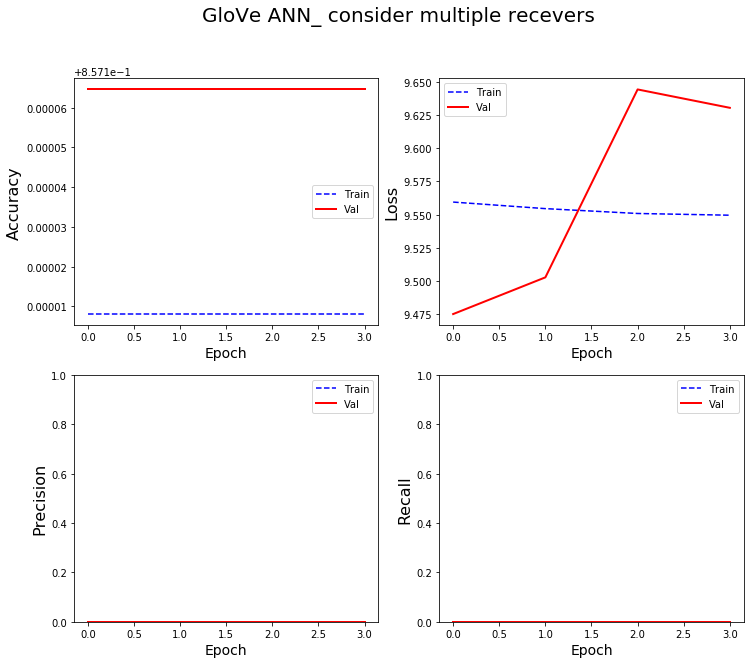

In [12]:
figName = "GloVe ANN_ consider multiple recevers"

metrics =  ['accuracy', 'loss', 'precision', 'recall']
fig = plt.figure()
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], 'b', linestyle="--", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], 'r', label='Val',linewidth=2.0)
    plt.xlabel('Epoch',fontsize = 14)
    plt.ylabel(name, fontsize = 16)
    if metric == 'precision' or metric == 'recall':
      plt.ylim([0.0,1])
    else:
        plt.ylim([plt.ylim()[0], plt.ylim()[1]])

    plt.legend()
fig.suptitle(figName,fontsize=20)
fig.savefig(figName+'.png')

## Try ANN with weight

In [13]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(labels),labels)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 2.6316886780753967,
 1: 1.5797845860376394,
 2: 0.4274146243218408,
 3: 1.3423906382810493,
 4: 2.2752010184937013,
 5: 2.140845869639232,
 6: 0.5010513858372057}

In [14]:
# create a model
model = tf.keras.Sequential()

# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(500, activation='sigmoid',input_shape=(MAX_SEQUENCE_LENGTH,)))
# Add another:
model.add(layers.Dense(500, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.1)))
# Add a softmax layer with 10 output units:
model.add(layers.Dense(7, activation='softmax'))

In [15]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


# compile model
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(), #CategoricalCrossentropy
              metrics=METRICS)
model.summary();

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_6 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 707       
Total params: 551,807
Trainable params: 551,807
Non-trainable params: 0
_________________________________________________________________


In [16]:
# train model
history = model.fit(data, encodeLabels, epochs=20, class_weight=class_weights, validation_split=0.4, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 203730 samples, validate on 135821 samples
Epoch 1/20
203730/203730 [==============================] - 46s 225us/sample - loss: 11.5171 - tp: 1.0000 - fp: 2.0000 - tn: 1222378.0000 - fn: 203729.0000 - accuracy: 0.8571 - precision: 0.3333 - recall: 4.9085e-06 - auc: 0.6414 - val_loss: 11.2613 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 814926.0000 - val_fn: 135821.0000 - val_accuracy: 0.8572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5274
Epoch 2/20
203730/203730 [==============================] - 43s 211us/sample - loss: 11.1657 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 1222380.0000 - fn: 203730.0000 - accuracy: 0.8571 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6406 - val_loss: 11.4919 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 814926.0000 - val_fn: 135821.0000 - val_accuracy: 0.8572 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6102
Epoch 3/20
203730/203730 [

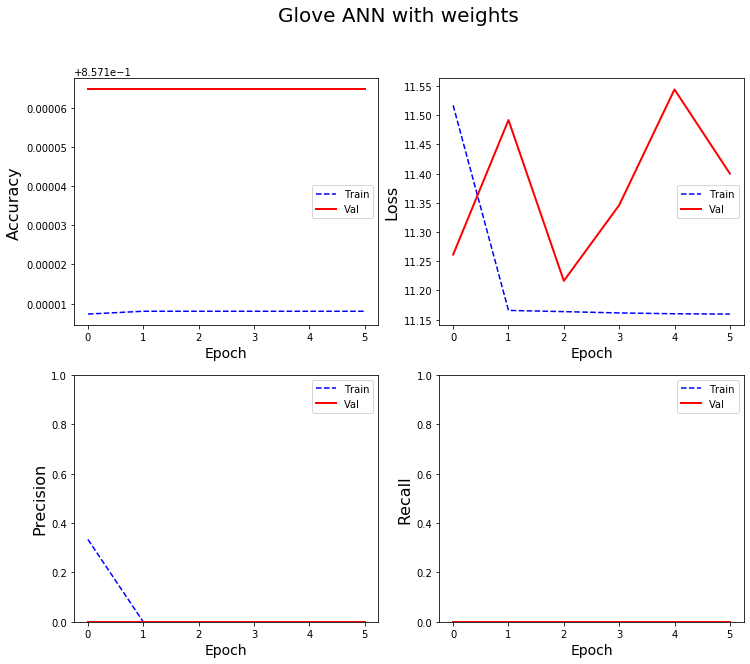

In [17]:
figName = "Glove ANN with weights"

metrics =  ['accuracy', 'loss', 'precision', 'recall']
fig = plt.figure()
for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], 'b', linestyle="--", label='Train')
    plt.plot(history.epoch, history.history['val_'+metric], 'r', label='Val',linewidth=2.0)
    plt.xlabel('Epoch',fontsize = 14)
    plt.ylabel(name, fontsize = 16)
    if metric == 'precision' or metric == 'recall':
      plt.ylim([0.0,1])
    else:
        plt.ylim([plt.ylim()[0], plt.ylim()[1]])

    plt.legend()
fig.suptitle(figName,fontsize=20)
fig.savefig(figName+'.png')